## Minimal Example on text2img with text LoRA + unet LoRA

With recent update, using `--train_text_encoder` will also save LoRA for text encoder. This notebook shows you how to make inference with them.

*Note: These datasets are obviously copywrited so don't use them for anything else...? I just really liked playing Overwatch*

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

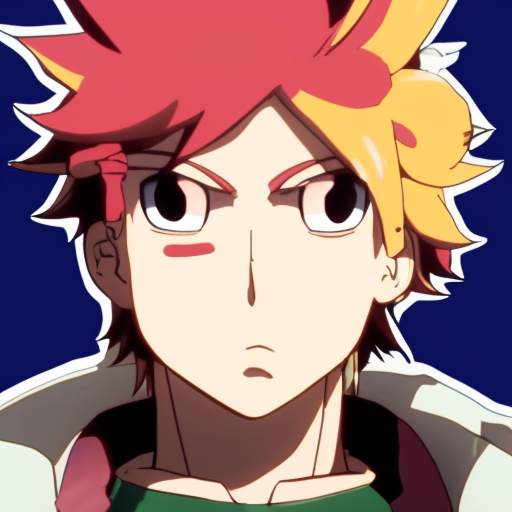

In [70]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda:1"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

prompt = "game character bnha"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

image  # nice, but that's the base model.

  0%|          | 0/50 [00:00<?, ?it/s]

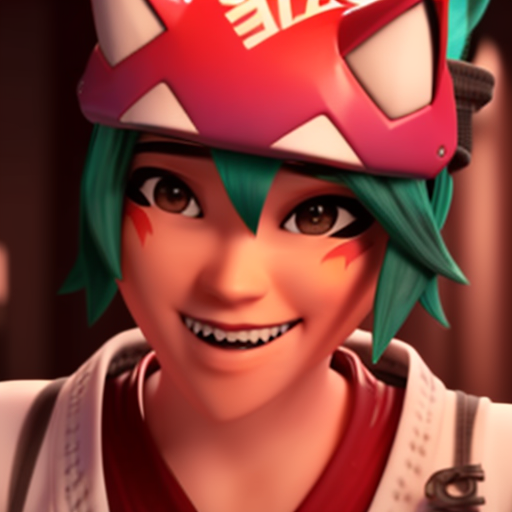

In [71]:
from lora_diffusion import monkeypatch_lora, tune_lora_scale


monkeypatch_lora(pipe.unet, torch.load("../lora_kiriko.pt"))
monkeypatch_lora(pipe.text_encoder, torch.load("../lora_kiriko.text_encoder.pt"), target_replace_module=["CLIPAttention"])
tune_lora_scale(pipe.unet, 1.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image.save("../contents/lora_with_clip.jpg")
image # Wow ok, now I might have to deal with a lawsuite for this.

  0%|          | 0/50 [00:00<?, ?it/s]

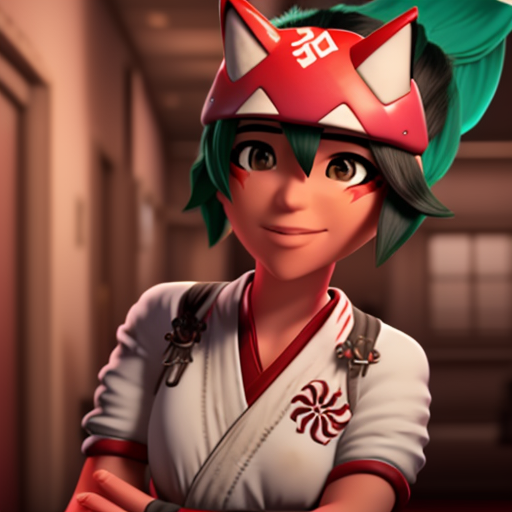

In [72]:
torch.manual_seed(1)
prompt = "game character bnha, wearing a red shirt, riding a donkey"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image # nice fidelity, but clearly overfitting.

So we see that the model is overfitting. Let's tune $\alpha$ to see if we can get better results.
Let's tune it for both unet and text encoder.

  0%|          | 0/50 [00:00<?, ?it/s]

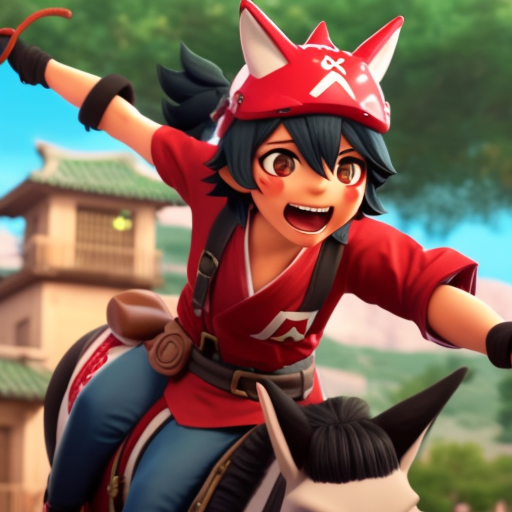

In [73]:
torch.manual_seed(1)
prompt = "game character bnha, wearing a red shirt, riding a donkey"
tune_lora_scale(pipe.unet, 0.5)
tune_lora_scale(pipe.text_encoder, 0.5)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image # Nice!

  0%|          | 0/50 [00:00<?, ?it/s]

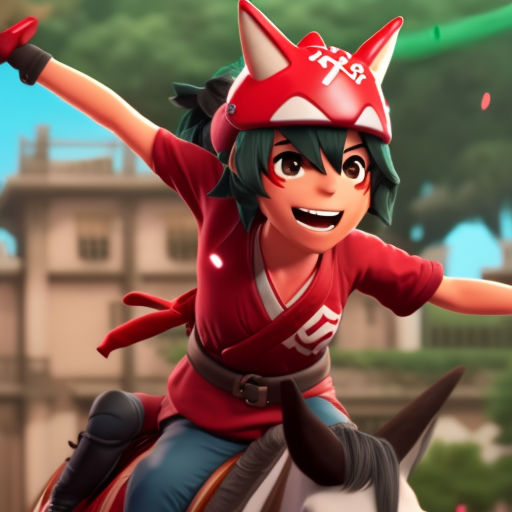

In [79]:
tune_lora_scale(pipe.unet, 0.9)
tune_lora_scale(pipe.text_encoder, 0.5)
torch.manual_seed(1)
image = pipe(prompt, num_inference_steps=50, guidance_scale=6.0).images[0]
image.save("../contents/lora_with_clip.jpg")
image # Nice! just like that, we can get a nice image by playing with the scale.

  0%|          | 0/50 [00:00<?, ?it/s]

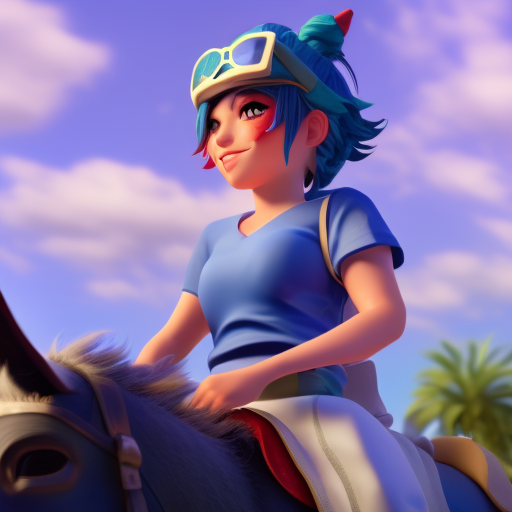

In [80]:
tune_lora_scale(pipe.unet, 0.5)
tune_lora_scale(pipe.text_encoder, 0.5)
torch.manual_seed(2)
prompt = "female game character bnha, wearing a blue Tshirt and sunglasses, riding a donkey, 4K render, trending on artstation, masterpiece"
image = pipe(prompt, num_inference_steps=50, guidance_scale=5.).images[0]
image # this is nice output i guess, so other tricks still works here, but that you have so much more control.

  0%|          | 0/60 [00:00<?, ?it/s]

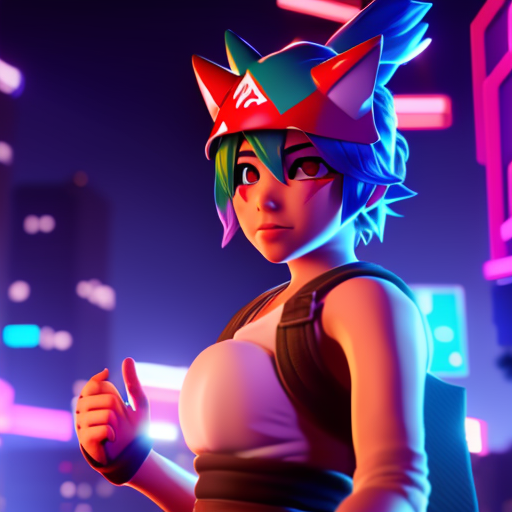

In [98]:
tune_lora_scale(pipe.unet, 0.6)
tune_lora_scale(pipe.text_encoder, 0.9)
torch.manual_seed(5)
prompt = "female game character bnha, neon city background, 4K render, trending on artstation, masterpiece"
image = pipe(prompt, num_inference_steps=60, guidance_scale=9.).images[0]
image # this works too. I'm just trying out bunch of ideas.